### Model Ivar using sky

In [63]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from scipy.stats import binned_statistic
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
output_notebook()
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV

sys.path.append("../")
from importlib import reload
import stack_spectra
reload(stack_spectra)

Loading BokehJS ...

<module 'stack_spectra' from '../stack_spectra.py'>

In [64]:
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [65]:
spec = desispec.io.read_spectra(my_path /  "spectra_bright.fits")
zcat = Table.read(my_path / "zcat_bright.fits")
flux_cam = spec.flux
wave_cam = spec.wave
ivar_cam = spec.ivar

INFO:spectra.py:253:read_spectra: iotime 0.172 sec to read spectra_bright.fits at 2021-04-25T16:05:59.570860


In [66]:
sky = desispec.io.read_spectra(my_path /  "sky_bright.fits")

INFO:spectra.py:253:read_spectra: iotime 0.154 sec to read sky_bright.fits at 2021-04-25T16:06:05.388881


In [67]:
sky_flux_cam = sky.flux
sky_ivar_cam = sky.ivar
sky_wave_cam = sky.wave

In [68]:
sky_flux, wave, sky_ivar = stack_spectra._coadd_cameras(sky_flux_cam, sky_wave_cam, sky_ivar_cam)

flux, wave, ivar = stack_spectra._coadd_cameras(flux_cam, wave_cam, ivar_cam)

# _, _, ivar_model = stack_spectra._coadd_cameras(flux_cam, wave_cam, proc_ivar)

In [55]:
n_obj = len(sky_ivar)
sky_var = 1/sky_ivar

ivar_model = np.zeros_like(ivar)

for i in range(n_obj):
    sky_mask = np.isfinite(sky_var[i])
    sky_var_interp = interp1d(wave[sky_mask], sky_var[i][sky_mask], fill_value="extrapolate", axis=-1)
    sky_var[i] = sky_var_interp(wave)
    sky_var[i] = sky_var[i]/median_filter(sky_var[i], 100) #takes out the overall shape of sky var

    #Create polunomial function of wavelength
    poly_feat_m = PolynomialFeatures(3)
    poly_feat_c = PolynomialFeatures(3)
    coef_m = poly_feat_m.fit_transform(wave[:,np.newaxis])
    coef_c = poly_feat_c.fit_transform(wave[:,np.newaxis])

    
    obj_var = 1/(ivar[i])
    obj_mask = np.isfinite(obj_var) #TODO Check for Nan values here
    obj_back = median_filter(obj_var[obj_mask],100, mode="nearest") 
    X = np.concatenate([(coef_m*sky_var[i][:,np.newaxis])[obj_mask], coef_c[obj_mask]], axis =1)+obj_back[:, np.newaxis]
    Y = obj_var[obj_mask]
    model = LinearRegression(fit_intercept=False, n_jobs=-1)
    model.fit(X,Y)
    y_predict = model.predict(X)
    residual = (Y-y_predict)/Y
    #correct for the overall shape of the residuals
    wave_bins = np.arange(wave.min(), wave.max(), 500)
    binned_residual, _, _ = binned_statistic(wave[obj_mask], residual, statistic="median", bins=wave_bins)
    interp_binned_res = interp1d((wave_bins[1:]+wave_bins[:-1])/2, binned_residual, kind="cubic", fill_value="extrapolate")
    large_res = interp_binned_res(wave[obj_mask])
    y_pred_adjust = large_res*Y + y_predict
    ivar_model[i][obj_mask] = 1/y_pred_adjust
    ivar_model[i][~obj_mask] = 0

<ipython-input-55-50298917278f>:19: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1/(ivar[i])


In [56]:
# index =1
p = figure(title="Spectra", x_axis_label='Wavelength', y_axis_label='Flux', plot_width=1000, plot_height=300, 
           y_range=(-1, 3)
          )
p.line(new_wl, wavg_f, legend_label="Temp.", line_width=2)
# p.line(new_wl, convolve(wavg_f,Gaussian1DKernel(3)), legend_label="Temp.", line_width=2, color="orange")

show(p)

NameError: name 'new_wl' is not defined

In [ ]:
proc_ivar= model_ivar(sky_i, ivar, wave)

<ipython-input-62-cf24b4635486>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(wave, (1/ivar_model[index])+5, label="model")
<ipython-input-62-cf24b4635486>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(wave, (1/ivar[index])+5, label ="observed")
<ipython-input-62-cf24b4635486>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(wave, ((1/ivar_model[index])-(1/ivar[index]))/(1/ivar[index]), label="model")
<ipython-input-62-cf24b4635486>:8: RuntimeWarning: invalid value encountered in subtract
  plt.plot(wave, ((1/ivar_model[index])-(1/ivar[index]))/(1/ivar[index]), label="model")


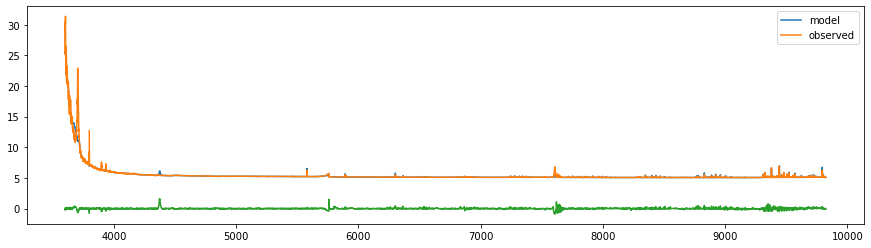

In [62]:
index = 15

plt.figure(figsize=(15,4))
plt.plot(wave, (1/ivar_model[index])+5, label="model")
plt.plot(wave, (1/ivar[index])+5, label ="observed")
plt.legend()
# plt.figure(figsize=(15,4))
plt.plot(wave, ((1/ivar_model[index])-(1/ivar[index]))/(1/ivar[index]), label="model")


# for c in ["b", "r", "z"]:
#     plt.plot(wave_cam[c], 1/ivar_cam[c][index], c="C0", label="observed")
#     plt.plot(wave_cam[c], 1/proc_ivar[c][index], c="C1", label="modelled")
# plt.ylim(0,10)


In [47]:
def model_ivar(ivar, sky_ivar, wave):
    n_obj = len(sky_ivar)
    sky_var = 1/sky_ivar

    ivar_model = np.zeros_like(ivar)

    for i in range(n_obj):
        sky_mask = np.isfinite(sky_var[i])
        sky_var_interp = interp1d(wave[sky_mask], sky_var[i][sky_mask], fill_value="extrapolate", axis=-1)
        sky_var[i] = sky_var_interp(wave)
        sky_var[i] = sky_var[i]/median_filter(sky_var[i], 100) #takes out the overall shape of sky var

        #Create polunomial function of wavelength
        poly_feat_m = PolynomialFeatures(3)
        poly_feat_c = PolynomialFeatures(3)
        coef_m = poly_feat_m.fit_transform(wave[:,np.newaxis])
        coef_c = poly_feat_c.fit_transform(wave[:,np.newaxis])


        obj_var = 1/(ivar[i])
        obj_mask = np.isfinite(obj_var) #TODO Check for Nan values here
        obj_back = median_filter(obj_var[obj_mask],200, mode="nearest") 
        X = np.concatenate([(coef_m*sky_var[i][:,np.newaxis])[obj_mask], coef_c[obj_mask]], axis =1)+obj_back[:, np.newaxis]
        Y = obj_var[obj_mask]
        model = LinearRegression(fit_intercept=False, n_jobs=-1)
        model.fit(X,Y)
        y_predict = model.predict(X)
        residual = (Y-y_predict)/Y
        #correct for the overall shape of the residuals
        wave_bins = np.arange(wave.min(), wave.max(), 400)
        binned_residual, _, _ = binned_statistic(wave[obj_mask], residual, statistic="median", bins=wave_bins)
        interp_binned_res = interp1d((wave_bins[1:]+wave_bins[:-1])/2, binned_residual, kind="cubic", fill_value="extrapolate")
        large_res = interp_binned_res(wave[obj_mask])
        y_pred_adjust = large_res*Y + y_predict
        ivar_model[i][obj_mask] = 1/y_pred_adjust
        ivar_model[i][~obj_mask] = 0
        
    return ivar_model

In [49]:
proc_ivar = {}
for cam in ["b", "r", "z"]:
    proc_ivar[cam] = model_ivar(ivar_cam[cam], sky_ivar_cam[cam], wave_cam[cam])

<ipython-input-47-cfa330d3d0b2>:20: RuntimeWarning: divide by zero encountered in true_divide
  obj_var = 1/(ivar[i])


In [50]:
_, _, model_ivar_cam = stack_spectra._coadd_cameras(flux_cam, wave_cam, proc_ivar)

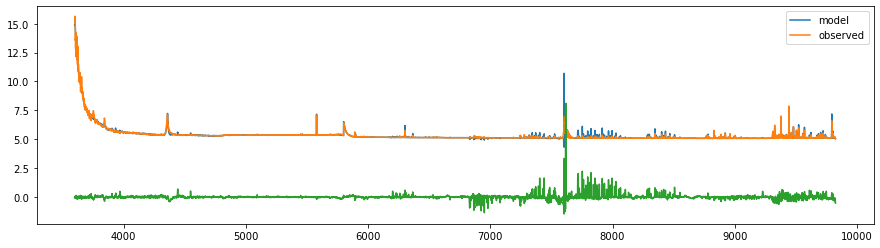

In [53]:
index = 0

plt.figure(figsize=(15,4))
plt.plot(wave, (1/model_ivar_cam[index])+5, label="model")
plt.plot(wave, (1/ivar[index])+5, label ="observed")
plt.legend()
# plt.figure(figsize=(15,4))
plt.plot(wave, ((1/model_ivar_cam[index])-(1/ivar[index]))/(1/ivar[index]), label="model")


# for c in ["b", "r", "z"]:
#     plt.plot(wave_cam[c], 1/ivar_cam[c][index], c="C0", label="observed")
#     plt.plot(wave_cam[c], 1/proc_ivar[c][index], c="C1", label="modelled")
# plt.ylim(0,10)


In [ ]:
sky_f = sky_f[test]
sky_i = sky_i[test]

In [ ]:
def process_sky_ivar(sky_ivar, sky_wave):
    n_obj = len(sky_ivar)
#     sky_wave = np.tile(sky_wave, (n_obj,1))
    sky_var = 1/sky_ivar
    for i in range(n_obj):
        mask = np.isfinite(sky_var[i])
        sky_var_interp = interp1d(sky_wave[mask], sky_var[i][mask], fill_value="extrapolate", axis=-1)
        sky_var[i] = sky_var_interp(sky_wave)
        sky_var[i] = sky_var[i]/median_filter(sky_var[i], 100)
    return sky_var

In [ ]:
sky_var = process_sky_ivar(sky_i, wave)

In [ ]:
plt.plot(sky_var[0])
plt.plot(sky_var[1])

In [ ]:
index = 0
plt.figure(figsize=(20,8))
plt.plot(wave, sky_var[index], label="Normalized Sky Var")
plt.plot(wave, (1/ivar)[index], label="spectra var")
plt.plot(wave, median_filter((1/ivar)[index],200, mode="nearest"), label="spectra var")
plt.ylim(0,10)
plt.legend()

In [ ]:
poly_feat_m = PolynomialFeatures(3)
poly_feat_c = PolynomialFeatures(3)

In [ ]:
coef_m = poly_feat_m.fit_transform(wave[:,np.newaxis])
coef_c = poly_feat_c.fit_transform(wave[:,np.newaxis])

In [ ]:
back = median_filter((1/ivar)[index],200, mode="nearest")
X = np.concatenate([coef_m*sky_var[index][:,np.newaxis], coef_c], axis =1)+back[:, np.newaxis]
Y = (1/ivar)[index]

In [ ]:
model = LinearRegression(fit_intercept=False, n_jobs=-1)
# model = LassoCV(fit_intercept=False, normalize=True, n_jobs=-1, n_alphas=200)

In [ ]:
model.fit(X,Y)

In [ ]:
y_predict = model.predict(X)

In [ ]:
residual = (Y-y_predict)/Y

In [ ]:
wave_bins = np.arange(wave.min(), wave.max(), 500)
binned_residual, _, _ = binned_statistic(wave, residual, statistic="median", bins=wave_bins)

In [ ]:
interp_binned_res = interp1d((wave_bins[1:]+wave_bins[:-1])/2, binned_residual, kind="cubic", fill_value="extrapolate")

In [ ]:
large_res = interp_binned_res(wave)

In [ ]:
plt.plot((wave_bins[1:]+wave_bins[:-1])/2, binned_residual)
plt.plot(wave, large_res)

In [ ]:
y_pred_adjust = large_res*Y + y_predict

In [ ]:
plt.figure(figsize=(15,4))
# plt.plot(sky_w, sky_f, c="gray", alpha=0.5)

plt.plot(wave, Y+1, label="Y")
# plt.plot(wave, flux[index] +2, c="gray", alpha=0.5)
# plt.plot(wave, y_predict+1, label="Y_predict")
plt.plot(wave, y_pred_adjust, label="Y_predict_adjusted")
plt.plot(wave, (Y-y_pred_adjust)/Y , label="fractional Residual")
plt.axhline(0,ls="--",c="k")
plt.legend()
# plt.xlim(8000,10000)
plt.ylim(-1, 2)

In [ ]:
plt.figure(figsize=(15,4))
# plt.plot(sky_w, sky_f, c="gray", alpha=0.5)



# plt.ylim(-1, 2)

In [ ]:
# index =1
p = figure(title="Spectra", x_axis_label='Wavelength', y_axis_label='Flux', plot_width=1000, plot_height=300, 
           y_range=(-1, 3)
          )
p.line(sky_w, Y, legend_label="Temp.", line_width=2)
p.line(sky_w, y_predict, legend_label="Temp.", line_width=2, color="orange")

show(p)

In [ ]:
from astropy.io import fits

In [ ]:
hdu = fits.open("/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/redrock-templates/master/rrtemplate-galaxy.fits")

In [ ]:
hdu.info()

In [ ]:
hdu[0].header

In [ ]:
flux = hdu[0].data

In [ ]:
#- Generate templates and resample to 0.1A grid that covers
#- z=0 to 1.85 for obsframe wavelengths 3500 to 11000, purposefully
#- avoiding Lyman-alpha to focus PCA variations on other lines
dw = 0.1
wave = np.arange(3500/(1+1.85), 11000+dw/2, dw)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(wave, flux[0,:]) # there are 10 templates. Any spectra can be a linear combination of these 10
plt.xlim(3700, 3740)

In [ ]:
flux.shape